<a href="https://colab.research.google.com/github/hugoo2/projet-ia/blob/main/Projet_final_Mouille_Roussel_Charlet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install torch torchvision transformers

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:02<00:00, 75758480.92it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')


model.config.num_labels = 10


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [21]:
import torch.optim as optim
import torch.nn as nn


optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()


def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    print('Finished Training')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train(model, trainloader, criterion, optimizer, device)


[100] loss: 0.052
[200] loss: 0.038
[300] loss: 0.051
[400] loss: 0.057
[500] loss: 0.049
[600] loss: 0.037
[700] loss: 0.044
[800] loss: 0.049
[900] loss: 0.042
[1000] loss: 0.051
[1100] loss: 0.040
[1200] loss: 0.052
[1300] loss: 0.049
[1400] loss: 0.040
[1500] loss: 0.043
Finished Training


In [22]:
torch.save(model.state_dict(), 'vit_cifar10.pth')


In [23]:
def test(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():  # Pas besoin de calculer les gradients lors de l'évaluation
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')


test(model, testloader, device)

Accuracy of the network on the test images: 97.42%


Files already downloaded and verified


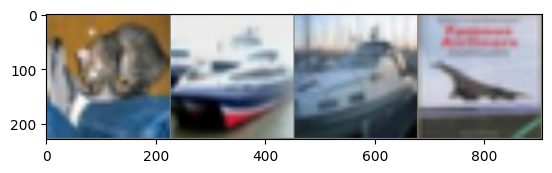

Predicted:  cat ship ship plane
Actual:  cat ship ship plane
Accuracy of the network on the test images: 97.42%


In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

model.load_state_dict(torch.load('vit_cifar10.pth'))
model.to(device)

model.eval()


images = images.to(device)
outputs = model(images).logits
_, predicted = torch.max(outputs, 1)


print('Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))
print('Actual: ', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

test(model, testloader, device)


In [29]:
model.load_state_dict(torch.load('vit_cifar10.pth'))
model.to(device)

test(model, testloader, device)


Accuracy of the network on the test images: 97.42%


In [32]:
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms
import torch

# on test avec une image de chien
url = 'https://i.f1g.fr/media/cms/704x396_cropupscale/2023/09/28/a2987bceb8ba1a60e5e6ee2c6f2176e4ffc009229c76318ea00607b45a1c1b98.jpg'  # Remplacez par l'URL de votre image
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Appliquer les mêmes transformations que celles utilisées pour l'entraînement
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img = transform(img).unsqueeze(0)  # Ajouter une dimension batch

model.load_state_dict(torch.load('vit_cifar10.pth'))
model.to(device)

model.eval()

img = img.to(device)
outputs = model(img).logits
_, predicted = torch.max(outputs, 1)

print('Predicted class: ', classes[predicted[0]])


Predicted class:  horse
